# Token Alignment

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from arsenal import iterview, timeit
from collections import Counter
from IPython.display import HTML
from genparse import CFG, FST, EPSILON, Float, CFGLM, add_EOS, prefix_transducer
from genparse.cfglm import locally_normalize, EOS, pcfg_check, explode, add_EOS, CharAlignedCFGLM
from genparse.util import LarkStuff, hf_tokenizer, about, show_grammar, normalize, bpe_wfst, display_table, bpe2term_approx
from genparse.inference import TraceSWOR

## Accounting for BPE's Tokenization Ambiguity with Transduction 

In [ ]:
lark_stuff = LarkStuff(r"""

start: NAME

NAME: /(a|b)*c/

""")
foo = lark_stuff.char_cfg(decay=.1)
foo = locally_normalize(foo)
assert len(foo.trim()) > 0
pcfg_check(foo)

In [ ]:
foo

In [ ]:
foo.cnf.language(3)

In [ ]:
lm = CFGLM(add_EOS(foo))

In [ ]:
trace = TraceSWOR()
for t in range(15):
    with trace:
        print(t, lm.sample(draw=trace))

In [ ]:
H = hf_tokenizer()
about(H.fst)

Let's shrink the BPE transducer down to something managable by limiting it alphabet 

In [ ]:
b2c = H.fst.prune_to_alphabet(None, foo.V | {''}).renumber
about(b2c)

In [ ]:
#b2c

We can look at our little language's strings thru the lense of their possible BPE sequences.  Notice that these strings are ambiguously mapped to BPE --- meaning that there are many BPE sequences that would give rise to the same string!

In [ ]:
for x in foo.cnf.language(3):
    print(x)
    bpe_x = (b2c @ FST.from_string(x, Float)).trim.project(0).epsremove.trim
    print('total weight of BPE sequences:', bpe_x.total_weight())
    display(bpe_x)
    print()

In [ ]:
tmp = (b2c @ foo)
assert len(tmp.trim()) > 0

In [ ]:
#tmp.trim().cnf.language(3)

In [ ]:
L = 5
c = Float.chart()
for x, w, in tmp.trim().cnf.language(5).items():
    y =  H.tokenizer.decode(x)
    if len(y) > L: continue    
    c[y] += w

In [ ]:
ambig = Float.chart({x: (b2c @ FST.from_string(x, Float)).trim.project(0).epsremove.trim.total_weight() for x in c})

In [ ]:
ccc = Float.chart()
for x in c:
    ccc[x] = c[x] / ambig[x]

In [ ]:
cc = Float.chart()
for x, w in foo.cnf.language(L+2).items():
    if len(x) > L: continue
    cc[''.join(x)] += w
cc

In [ ]:
ccc.assert_equal(cc, tol=1e-20)

In [ ]:
#cc.metric(c)

In [ ]:
#tmp.trim(bottomup_only=True)

In [ ]:
#show_grammar(tmp, showzero=True)

In [ ]:
#print(tmp.agenda().__str__(style_value=lambda k, v: (colors.light.red % v) if v > 1.000001 or v < 0 else v))

In [ ]:
#for q in c2t.states:      
#    for (a,b), r, w in c2t.arcs(q):
#        print(f'--{a or "ε"}:{b or "ε"}/{w}-->', r)

In [ ]:
#{x: v for x,v in tmp.agenda().items() if v > 1.001 or v < 0}

In [ ]:
#len(tmp.N - tmp.agenda(tol=1e-40, maxiter=np.inf).trim().keys()), len(tmp.N), len(tmp.agenda(tol=1e-40).trim())

In [ ]:
#tmp.cnf.language(4)

In [ ]:
#show_grammar(tmp)

In [ ]:
p = locally_normalize(tmp, tol=1e-40, maxiter=np.inf).trim()
pcfg_check(p)

In [ ]:
lm2 = CFGLM(add_EOS(p))

In [ ]:
#lm2.sample(verbose=1)

In [ ]:
#context = (64,65,6485,39305)
context = (64,65,6485,)

In [ ]:
char_context = H.tokenizer.decode(context)
char_context

In [ ]:
df = []
for x, w in sorted(normalize(lm2.p_next(context)).items(), key=lambda kv: -kv[1]):
    df.append((x, (H.tokenizer.decode([x]) if x != EOS else EOS), w))
pd.DataFrame(df, columns=['token_id', 'chars', 'prob']).set_index('token_id')

In [ ]:
Float.chart(normalize(lm.p_next(char_context)))

## Lexing

In [ ]:
lark_stuff = LarkStuff(r"""

start: "SELECT" WS STAR WS "FROM" WS NAME WS EOS

EOS: "</s>"
NAME: /[a-z]+/
STAR: "*"
WS: /[ ]/

""")

In [ ]:
foo = lark_stuff.char_cfg(.1)

In [ ]:
#foo['NAME'].trim().agenda()

In [ ]:
#foo.agenda()

In [ ]:
foo = locally_normalize(foo, tol=1e-100).trim()
assert len(foo) > 0

In [ ]:
#foo

In [ ]:
lm = CFGLM(add_EOS(foo))

In [ ]:
trace = TraceSWOR()
for _ in range(15):
   print('mass=', trace.root.mass)
   with trace:
       print(''.join(lm.sample(draw=trace)))

In [ ]:
cfg = lark_stuff.convert().renumber()

In [ ]:
c2t = lark_stuff.transducer(ignore='', decay=.0125); len(c2t.states)

The `lark` library will only lex it one way because it has a deterministic semantics for prioritized lexing:

In [ ]:
x = 'SELECT * FROM data'

In [ ]:
list(lark_stuff.lex(x))

However, this string can lex many different ways:

In [ ]:
ambig = (FST.from_string(x, Float) @ c2t).trim.project(1).epsremove.trim.to_cfg().cnf.language(15)

In [ ]:
#ambig

It might be fine to allow ambiguous lexing because very few of the possible lexing options will survive the parser.

In [ ]:
for y in ambig:
    v = cfg.prefix_weight(y)   # show all options with a nonzero prefix weight
    if v == 0: continue
    print(v, y)

In [ ]:
#((FST.from_string('SELECT', Float) @ c2t) @ P.T @ cfg).trim().cnf.language(15)

In [ ]:
#(P.T @ cfg).trim().cnf.language(100)

In [ ]:
cfg_t = (c2t.renumber @ cfg).trim()
pcfg_t = locally_normalize(cfg_t, tol=1e-100, maxiter=10_000_000)

In [ ]:
pcfg_check(pcfg_t)

In [ ]:
cfg_t('SELECT * FROM data </s>')

In [ ]:
cfg_t('SELECT * FROM data </s>')

In [ ]:
lm = CFGLM(add_EOS(pcfg_t.cnf))

In [ ]:
for _ in range(10):
    print(''.join(lm.sample()))

In [ ]:
lm.p_next('SELECT * FROM ')

## BPE Basics

In [ ]:
hf_tk = hf_tokenizer()
tokenizer = hf_tk.tokenizer

In [ ]:
b2c = hf_tk.fst
len(b2c.states)

In [ ]:
x = 'SELECT * FROM data'
b = tokenizer.encode(x)
b

In [ ]:
[tokenizer.decode([bb]) for bb in b]

In [ ]:
with timeit('composition'):
    c = FST.from_string(tuple(b), Float) @ b2c
about(c)

In [ ]:
c.trim

We can build this "transducer" more efficiently

In [ ]:
t = bpe2term_approx(tokenizer, tokenizer.encode(x)).epsremove.trim
t

## BPE Ambiguity

In [ ]:
with timeit('composition'):
    bs = b2c @ FST.from_string(x, Float)
with timeit('trim'):
    bs.trim
about(bs)

In [ ]:
#bs.trim

The automaton below describes all the BPE sequences that generate the string `x`:

In [ ]:
bs.trim.project(0).epsremove.trim

To see all the BPE sequences that generate `x` run the cell below:

In [ ]:
#for y in bs.trim.project(0).epsremove.trim.to_cfg().language(10):
#    print(tokenizer.decode(y), y)

## A Basic Alignment Algorithm

In [ ]:
lark_stuff = LarkStuff(r"""
start: "SELECT" WS select_expr WS "FROM" WS from_expr [WS "WHERE" WS bool_condition] [WS "GROUP BY" WS var_list] [WS "ORDER BY" WS orderby_expr] WS EOS
EOS: "</s>"
select_expr: STAR | select_list
bool_condition: bool_expr | "(" bool_condition WS "AND" WS bool_condition ")" | "(" bool_condition WS "OR" WS bool_condition ")"
bool_expr: var "=" value | var ">" value | var "<" value
from_expr: "data"
orderby_expr: var_list WS "ASC" | var_list WS "DESC"
select_list: select_var ("," WS select_var)*
var_list: var ("," WS var)*
select_var: var | "AVG(" var ")" | "MEDIAN(" var ")" | "COUNT(" var ")"
var: "age" | "gender" | "year" | "state_color" | "zipcode" | "vote" | "race_ethnicity"
value: NUMBER | "red" | "blue" | "white" | "black" | "latino" | "republican" | "democrat" | "male" | "female"
STAR: "*"
NUMBER: /\d+/
WS: " "
""")

foo = lark_stuff.char_cfg(.7)
foo = locally_normalize(foo, tol=1e-100).trim()
assert len(foo) > 0
lm = CFGLM(foo)

In [ ]:
print(''.join(lm.sample()))

In [ ]:
H = hf_tokenizer()

In [ ]:
bpe_lm = CharAlignedCFGLM(lm=lm, words={x for _, x in H.pairs}, eos=H.tokenizer.eos_token)

In [ ]:
lm.p_next('')

In [ ]:
bpe_lm.p_next('')

In [ ]:
lm.p_next('SELECT ')

In [ ]:
bpe_lm.p_next('SELECT ')

In [ ]:
ys = bpe_lm.sample(verbose=0)
ys

## Avoiding Distortion in Tokenization Alignment. 


Let $p$ be some original CFG-LM over character strings $a \in A^*$.

Let $p'$ be the "BPE transform" of $p$; $p'$ is a distribution over BPE strings $b \in B^*$.

The sets $A^*$ and $B^*$ are related through the functions $\mathrm{encode}$ and $\mathrm{decode}$.

We want 

$$
\forall a\colon\quad   p(a) = \sum_{b\colon\ \mathrm{decode}(b) = a} p'(b)
$$

We would like to define $p'$ such that this property holds because it ensures that the process

1. $b \sim p'$
2. $a = \mathrm{decode}(b)$

generates $a$ that is distributed $p$.

Open question: does there exist an efficient incremental generative process $p'$ that ensures $p = p'$.

The code below is an attempt to understand the distortion in the char-alignment adaptor.

In [6]:
_cfg = CFG.from_string("""

1: S -> a
1: S -> aa
1: S -> aaa

""", Float)
c_lm = CFGLM(locally_normalize(explode(add_EOS(_cfg)), tol=1e-100).trim())

In [24]:
c_lm.cfg

Grammar {
  1.0: 0 → 1 ▪
  0.3333333333333333: 1 → a #
  0.3333333333333333: 1 → a a #
  0.3333333333333333: 1 → a a a #
}

In [7]:
tokens = _cfg.V | {'#', EOS}

In [9]:
tokens

{'#', 'a', 'aa', 'aaa', '▪'}

In [10]:
a_lm = CharAlignedCFGLM(c_lm, tokens, EOS)

In [11]:
def generation_tree(lm, **opts):
    tracer = TraceSWOR()
    D = Float.chart()
    while tracer.root.mass > 0:
        with tracer:
            s, p = lm.sample(draw=tracer, prob=True, **opts)
            D[s] += p
    D = Float.chart((k, D[k]) for k in sorted(D))
    return D, tracer

In [12]:
C, tracer_char = generation_tree(c_lm)
display_table([[C, tracer_char.root.graphviz()]])

key,value
"('a', '#')",0.3333333333333333
"('a', 'a', '#')",0.3333333333333333
"('a', 'a', 'a', '#')",0.3333333333333333


In [13]:
A, tracer_aligned = generation_tree(a_lm)
display_table([[A, tracer_aligned]])

key,value
a#,0.14438502673796794
aa#,0.32085561497326204
aaa#,0.53475935828877


In [52]:
D_chunks, tracer_aligned_chunks = generation_tree(a_lm, chunked=True)
display_table([[D_chunks, tracer_aligned_chunks]])

key,value
"('a', '#', '▪')",0.14438502673796794
"('a', 'a', '#', '▪')",0.14438502673796794
"('a', 'a', 'a', '#', '▪')",0.14438502673796794
"('a', 'aa', '#', '▪')",0.09625668449197862
"('aa', '#', '▪')",0.1764705882352941
"('aa', 'a', '#', '▪')",0.1764705882352941
"('aaa', '#', '▪')",0.11764705882352941


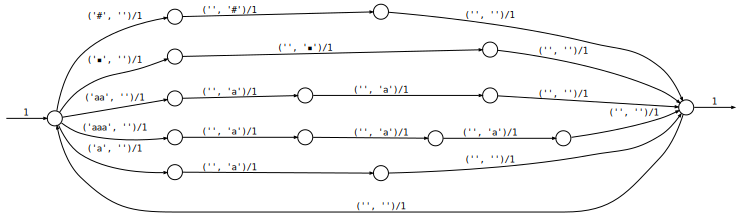

In [15]:
B = bpe_wfst([(w, list(w)) for w in tokens])
B

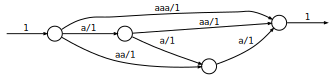

In [22]:
(B @ FST.from_string('aaa', Float)).trim.project(0).epsremove.trim

In [25]:
(B @ FST.from_string('aa', Float)).trim.project(0).epsremove.trim.total_weight()

2.0

In [26]:
b_lm = CFGLM(locally_normalize((B @ c_lm.cfg).trim(), tol=1e-100).trim())

In [27]:
L = b_lm.cfg.language(10)

In [28]:
display_table([generation_tree(b_lm)])

key,value
"('a', '#')",0.14285714285714288
"('a', 'a', '#')",0.14285714285714288
"('a', 'a', 'a', '#')",0.14285714285714288
"('a', 'aa', '#')",0.14285714285714288
"('aa', '#')",0.14285714285714288
"('aa', 'a', '#')",0.14285714285714288
"('aaa', '#')",0.14285714285714288


In [70]:
PL = L.project(lambda y: ''.join(y).strip(EOS))

In [71]:
display_table([[C.project(''.join), A, PL]], headings=['target', 'composition', 'grafting-approximation'])